<a href="https://colab.research.google.com/github/LoopGlitch26/WaifuGAN-Epitome/blob/main/Beta_Test_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WaifuGAN Epitome : A lite-mode Deep Convolutional Generative Adversarial Network model based non-existing Anime Avatars creation using PyTorch-Lightning

I am going to use [Anime Face Dataset](https://github.com/bchao1/Anime-Face-Dataset) by Mckinsey666, from [Kaggle](https://www.kaggle.com/splcher/animefacedataset) version.

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d splcher/animefacedataset
!unzip -qq ./animefacedataset.zip
path = '/content/images'

I am going to use PyTorch-Lightning for this project. Lightning makes coding complex neural networks very simple by removing the boilerplates and train loop used in PyTorch for AI research.

In [ ]:
!pip install pytorch-lightning -q
!pip install pytorch-lightning-bolts -q

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.optim import Adam
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import pytorch_lightning as pl

I'm going to use a Deep Convolutional GAN which was developed in 2015, whose original paper can be found [here](https://arxiv.org/pdf/1511.06434v1.pdf)

DCGAN Architecture



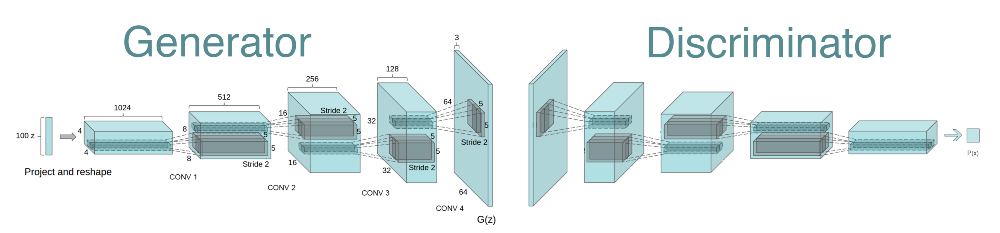

Important features of DCGAN:
* Use convolutions without any pooling layers
* Use batchnorm in both the generator and the discriminator
* Don't use fully connected hidden layers
* Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
* Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

## Tensors
I will represent data using Tensors. Tensors are a generalization of matrices: for example, a stack of three matrices with the amounts of red, green, and blue at different locations in a 64 x 64 pixel image is a tensor with the shape 3 x 64 x 64. Tensors are easy to manipulate and supported by PyTorch.

## Batches
While you could train your model after generating one image, it is extremely inefficient and leads to less stable training. In GANs, and in machine learning in general, you will process multiple images per training step. These are called batches.
This means that your generator will generate an entire batch of images and receive the discriminator's feedback on each before updating the model. The same goes for the discriminator, it will calculate its loss on the entire batch of generated images as well as on the reals before the model is updated

In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), ret=False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ret:
        return image_grid.permute(1, 2, 0).squeeze()
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Generator
Generator learns the data distribution and creates realistic looking fake images.
The generator will be using 4 layers (3 hidden layers + 1 output layer), consisting of Transposed Convolution, Batch Normalisation and activation function layer.



In [5]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        in_channels: the number of channels of the output image, a scalar
    '''
    def __init__(self, in_channels=3, z_dim=100):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.create_upblock(z_dim, 1024, kernel_size=4, stride=1, padding=0),
            self.create_upblock(1024, 512, kernel_size=4, stride=2, padding=1),
            self.create_upblock(512, 256, kernel_size=4, stride=2, padding=1),
            self.create_upblock(256, 128, kernel_size=4, stride=2, padding=1),
            self.create_upblock(128, 3, kernel_size=4, stride=2, padding=1, final_layer=True),
        )

    def create_upblock(self, in_channels, out_channels, kernel_size=5, stride=2, padding=1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Tanh()
                )
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True))

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''      
        assert len(noise.shape) == 4, 'random vector of shape=(N, 100, 1, 1)'

        return self.gen(noise)

# Noise
To be able to use the generator model, I will need to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- just like a random seed. I will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, I will generate all the noise vectors at once.

In [6]:
def get_noise(cur_batch_size, z_dim, device):
    noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
    return noise

# Discriminator
The architecture of a Discriminator is same as that of a normal image classification model. It contains Convolution layers, Activation layer and BatchNormalisation. In the DCGAN model, strides are used instead of pooling to reduce the size of a kernel. Also there is no Fully Connected layer in the network. Leaky ReLU with leak slope 0.2 is used.

In [7]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''  
    def __init__(self, im_chan=3, hidden_dim=32):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4, stride=1),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 4, stride=2),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''      
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride), 
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2))
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride))

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''      
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

# Training
Images are scaled to be in range of tanh activation, [-1, 1]. Training was done with a mini-batch size of 128 and Adam optimizer with a learning rate of 0.0002. All the weights initialised with Normal distribution $\mu(0, 0.02)$.

## Parameters:

* criterion: the loss function
* n_epochs: the number of times you iterate through the entire dataset when training
* z_dim: the dimension of the noise vector
* display_step: how often to display/visualize the images
* batch_size: the number of images per forward/backward pass
* lr: the learning rate
* beta_1, beta_2: the momentum term
* device: the device type

In [8]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 100
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

To tranform the image values to be between -1 and 1 (the range of the tanh activation)

In [9]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Dataloader
Here I'm loading data from Kaggle dataset

In [10]:

class ImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.files = glob(f'{path}/*')

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        label = file.split('/')[-1]
        image = Image.open(file)
        if self.transform:
            image = self.transform(image)
        return image, label


ds = ImageDataset(path, transform=transform)
dataloader = dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

Initialize the weights to the normal distribution with mean 0 and standard deviation 0.02

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
mean_generator_loss = []
mean_discriminator_loss = []

class GAN(pl.LightningModule):
    def __init__(self, learning_rate, in_channels=3, hidden_dim=32, z_dim=100, **kwargs):
        super().__init__()

        self.z_dim = z_dim
        self.learning_rate = learning_rate

        self.gen = Generator(in_channels, z_dim=z_dim).to(device)
        self.disc = Discriminator(im_chan=in_channels, hidden_dim=hidden_dim).to(device)

        self.gen.apply(weights_init)
        self.disc.apply(weights_init)

        self.save_hyperparameters()

    def forward(self, noise):
        return self.gen(noise)

    def disc_step(self, x, noise):
        fake_images = self.gen(noise)
        real_logits = self.disc(x)
        fake_logits = self.disc(fake_images.detach())
        assert real_logits.shape == fake_logits.shape, f"Real and fake logit shape are different: {real_logits.shape} and {fake_logits.shape}"
        real_loss = criterion(real_logits, torch.ones_like(real_logits))
        fake_loss = criterion(fake_logits, torch.zeros_like(fake_logits))
        disc_loss = (fake_loss + real_loss) / 2
        assert disc_loss is not None
        self.log('disc_loss', disc_loss, on_epoch=True, prog_bar=True)
        return disc_loss

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step        

    def gen_step(self, x, noise):
        fake_images = self.gen(noise)
        fake_logits = self.disc(fake_images)
        fake_loss = criterion(fake_logits, torch.ones_like(fake_logits))
        gen_loss = fake_loss
        assert gen_loss is not None
        self.log('gen_loss', gen_loss, on_epoch=True, prog_bar=True)
        return gen_loss

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

    def training_step(self, batch, batch_idx, optimizer_idx):
        x, _ = batch
        x = real = x.to(device)
        noise = get_noise(real.shape[0], self.z_dim, device=device)
        assert real.shape[1:] == (3, 64, 64), f"batch image data shape is incorrect: {real.shape}"

        if batch_idx % display_step == 0 and optimizer_idx == 0:
            fake_images = self.forward(noise)
            show_tensor_images(fake_images)

        loss = None
        if optimizer_idx == 0:
            loss = self.gen_step(real, noise)

        if optimizer_idx == 1:
            loss = self.disc_step(real, noise)
        return loss

    def configure_optimizers(self):
        lr = self.hparams.learning_rate

        opt_g = torch.optim.Adam(self.gen.parameters(),
                                 lr=lr,
                                 betas=(beta_1, beta_2))
        opt_d = torch.optim.Adam(self.disc.parameters(),
                                 lr=lr,
                                 betas=(beta_1, beta_2))
        return [opt_g, opt_d]
    

In [24]:
model = GAN(learning_rate=lr, z_dim=z_dim)
trainer = pl.Trainer(max_epochs=2, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | gen  | Generator     | 12.7 M
1 | disc | Discriminator | 430 K 
---------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.356    Total estimated model params size (MB)


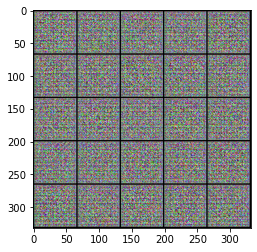

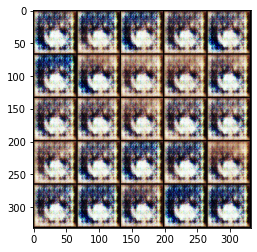

In [25]:
trainer.fit(model, dl)



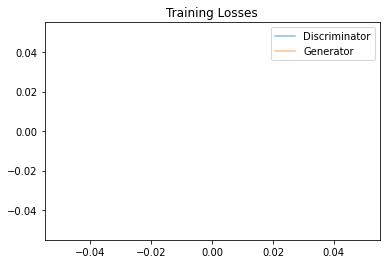

In [26]:
import numpy as np
fig, ax = plt.subplots()
plt.plot(mean_discriminator_loss, label='Discriminator', alpha=0.5)
plt.plot(mean_generator_loss, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [27]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# define two collections of activations
act1 = random(10*2048)
act1 = act1.reshape((10,2048))
act2 = random(10*2048)
act2 = act2.reshape((10,2048))
# fid between act1 and act1
fid = calculate_fid(act1, act1)
print('FID (same): %.3f' % fid)
# fid between act1 and act2
fid = calculate_fid(act1, act2)
print('FID (different): %.3f' % fid)

FID (same): -0.000
FID (different): 358.507


In [ ]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode
inception_model.fc = torch.nn.Identity() 


In [ ]:
from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

In [ ]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

In [ ]:
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: frechet_distance
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    #### START CODE HERE ####
    return (mu_x - mu_y).dot(mu_x - mu_y) + torch.trace(sigma_x) + torch.trace(sigma_y) - 2*torch.trace(matrix_sqrt(sigma_x @ sigma_y)) 
    #### END CODE HERE ####

In [ ]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [ ]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [ ]:
fake_features_list = []
real_features_list = []



dataloader = dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Needed as is for autograding
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL

# Calculate the covariance matrix for the fake and real features
# and also calculate the means of the feature over the batch (for each feature dimension mean)
#### START CODE HERE ####
mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)
#### END CODE HERE ####

In [ ]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')


In [ ]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())